In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nuthangowda","key":"3b15e291dc050f84ec9c5720fcfc2df8"}'}

In [3]:
!mkdir -p ~/.kaggle                                               
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [9]:
!kaggle datasets download ahmedhaytham/where-am-i

100% 4.06G/4.06G [01:07<00:00, 51.7MB/s]
100% 4.06G/4.06G [01:07<00:00, 65.0MB/s]


In [ ]:
!unzip '/content/where-am-i.zip'

In [38]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Sequential, models
import matplotlib.pyplot as plt 
from glob import glob 

In [39]:
training_dir = '/content/Data/train'
testing_dir = '/content/Data/test'
validation_dir = '/content/Data/Val'

In [40]:
BATCH_SIZE = 64
image_size = 200
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(training_dir, shuffle=True, image_size=(image_size, image_size))
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(testing_dir, shuffle=True, image_size=(image_size, image_size))
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(validation_dir, shuffle=True, image_size=(image_size, image_size))



Found 1800 files belonging to 3 classes.
Found 600 files belonging to 3 classes.
Found 300 files belonging to 3 classes.


In [41]:
class_names = train_dataset.class_names
class_names

['cairo', 'moscow', 'paris']

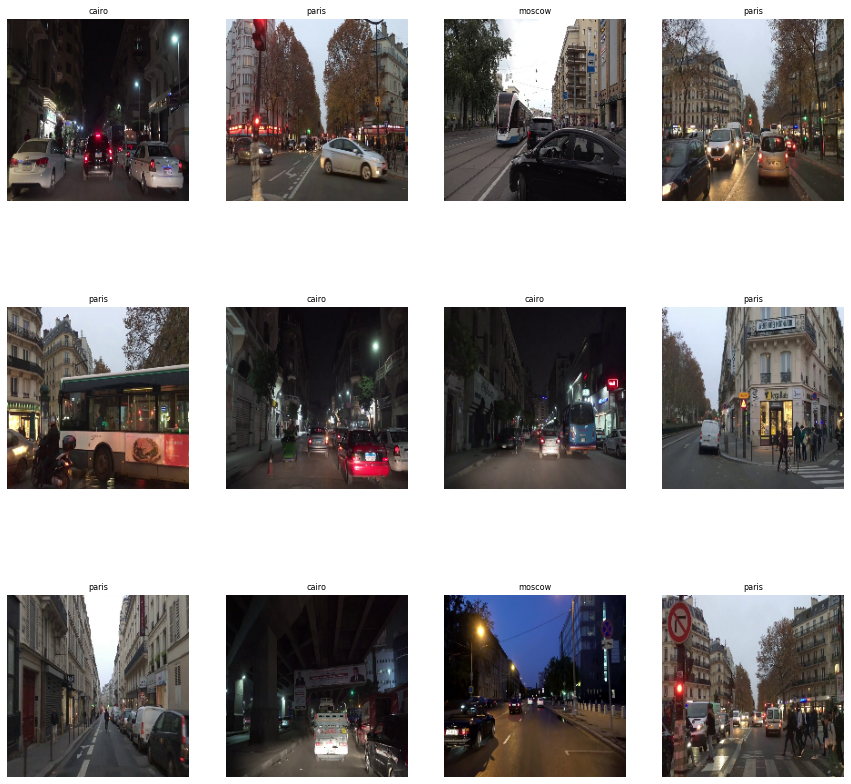

In [42]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]], fontsize=8)
        plt.axis("off")

In [43]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model

resnet = ResNet50(include_top=False, weights = 'imagenet', input_shape= (image_size, image_size, 3), pooling = 'max')

output = resnet.layers[-1].output
output = tf.keras.layers.Flatten()(output)
resnet = Model(resnet.input, output)

res_name = []
for layer in resnet.layers:
    res_name.append(layer.name)

In [44]:
res_name[:-22]

['input_2',
 'conv1_pad',
 'conv1_conv',
 'conv1_bn',
 'conv1_relu',
 'pool1_pad',
 'pool1_pool',
 'conv2_block1_1_conv',
 'conv2_block1_1_bn',
 'conv2_block1_1_relu',
 'conv2_block1_2_conv',
 'conv2_block1_2_bn',
 'conv2_block1_2_relu',
 'conv2_block1_0_conv',
 'conv2_block1_3_conv',
 'conv2_block1_0_bn',
 'conv2_block1_3_bn',
 'conv2_block1_add',
 'conv2_block1_out',
 'conv2_block2_1_conv',
 'conv2_block2_1_bn',
 'conv2_block2_1_relu',
 'conv2_block2_2_conv',
 'conv2_block2_2_bn',
 'conv2_block2_2_relu',
 'conv2_block2_3_conv',
 'conv2_block2_3_bn',
 'conv2_block2_add',
 'conv2_block2_out',
 'conv2_block3_1_conv',
 'conv2_block3_1_bn',
 'conv2_block3_1_relu',
 'conv2_block3_2_conv',
 'conv2_block3_2_bn',
 'conv2_block3_2_relu',
 'conv2_block3_3_conv',
 'conv2_block3_3_bn',
 'conv2_block3_add',
 'conv2_block3_out',
 'conv3_block1_1_conv',
 'conv3_block1_1_bn',
 'conv3_block1_1_relu',
 'conv3_block1_2_conv',
 'conv3_block1_2_bn',
 'conv3_block1_2_relu',
 'conv3_block1_0_conv',
 'conv3_

In [45]:
set_trainable = False
for layer in resnet.layers:
    if layer.name in res_name[-22:]:
        set_trainable = True
    if set_trainable:
        layer.trainable = True

    else:
        layer.trainable = False

In [46]:
resnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [47]:
resnet

In [49]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout



model6 = Sequential()
model6.add(resnet)
model6.add(Dense(2048, activation='relu'))
model6.add(Dense(1024, activation='relu'))
model6.add(Dense(512, activation='relu'))
# model6.add(Dense(256, activation='relu'))
model6.add(Dense(128, activation='relu'))

model6.add(Dense(3, activation='softmax'))


model6.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 2048)              23587712  
                                                                 
 dense_5 (Dense)             (None, 2048)              4196352   
                                                                 
 dense_6 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_7 (Dense)             (None, 512)               524800    
                                                                 
 dense_8 (Dense)             (None, 128)               65664     
                                                                 
 dense_9 (Dense)             (None, 3)                 387       
                                                                 
Total params: 30,473,091
Trainable params: 15,816,707


In [51]:
model6.compile(optimizer = 'adam', 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['accuracy'])

In [52]:
EPOCHS = 10
history6 = model6.fit(
    train_dataset,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data = val_dataset,
    verbose = 1,
) 

Epoch 1/10
57/57 [==============================] - 35s 342ms/step - loss: 2.7816 - accuracy: 0.8533 - val_loss: 23.3057 - val_accuracy: 0.6767
Epoch 2/10
57/57 [==============================] - 18s 286ms/step - loss: 0.0148 - accuracy: 0.9950 - val_loss: 33.7452 - val_accuracy: 0.6900
Epoch 3/10
57/57 [==============================] - 18s 291ms/step - loss: 1.9927e-04 - accuracy: 1.0000 - val_loss: 6.6096 - val_accuracy: 0.8733
Epoch 4/10
57/57 [==============================] - 18s 286ms/step - loss: 3.0115e-04 - accuracy: 1.0000 - val_loss: 2.1242 - val_accuracy: 0.9100
Epoch 5/10
57/57 [==============================] - 18s 287ms/step - loss: 1.4959e-04 - accuracy: 1.0000 - val_loss: 1.2069 - val_accuracy: 0.9367
Epoch 6/10
57/57 [==============================] - 18s 287ms/step - loss: 0.0026 - accuracy: 0.9989 - val_loss: 0.2891 - val_accuracy: 0.9567
Epoch 7/10
57/57 [==============================] - 18s 287ms/step - loss: 5.1340e-06 - accuracy: 1.0000 - val_loss: 0.2665 - va

In [53]:
scores = model6.evaluate(test_dataset)

19/19 [==============================] - 7s 274ms/step - loss: 0.3543 - accuracy: 0.9200


In [54]:
acc = history6.history['accuracy']
val_acc = history6.history['val_accuracy']

loss = history6.history['loss']
val_loss = history6.history['val_loss']

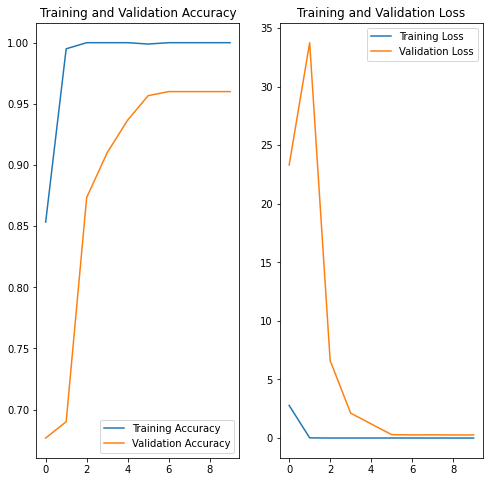

In [55]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [56]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

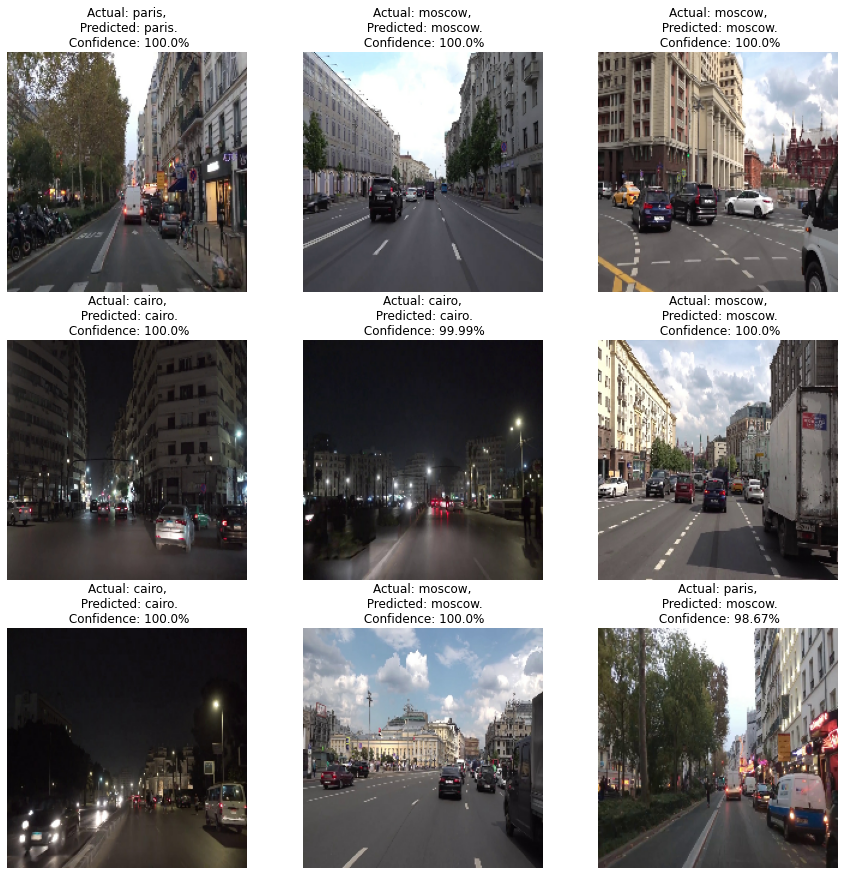

In [57]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model6, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")